In [ ]:
import numpy as np

class KMeansClassifier():
    "this is a k-means classifier"
    
    def __init__(self, k=3, initCent='random', max_iter=500 ):
        
        self._k = k                                         #变量名之前加_是私有变量，类之外的任何代码无法访问私有变量
        self._initCent = initCent                      
        self._max_iter = max_iter
        self._clusterAssment = None
        self._labels = None
        self._sse = None
        
    def _calEDist(self, arrA, arrB):                                #欧拉距离，两点之间的直线距离
        """
        功能：欧拉距离距离计算           
        输入：两个一维数组
        """
        return np.math.sqrt(sum(np.power(arrA-arrB, 2)))            #python一行命令就能进行复合运算,np.math.sqrt()
                                                                    #np.power()数组的元素分别求n次方。x2可以是数字，也可以是数组，但是x1和x2的列数要相同
    def _calMDist(self, arrA, arrB):                                #曼哈顿距离，
        """
        功能：曼哈顿距离距离计算
        输入：两个一维数组
        """
        return sum(np.abs(arrA-arrB))           


    def _randCent(self, data_X, k):
        """
        功能：随机选取k个质心
        输出：centroids #返回一个m*n的质心矩阵
        """
        n = data_X.shape[1] #获取特征的维数            
        centroids = np.empty((k,n))  #使用numpy生成一个k*n的矩阵，用于存储质心; 
        for j in range(n):
            minJ = min(data_X[:, j])
            rangeJ  = float(max(data_X[:, j] - minJ))
            #使用flatten拉平嵌套列表(nested list)
            centroids[:, j] = (minJ + rangeJ * np.random.rand(k, 1)).flatten()
        return centroids 
    
    def fit(self, data_X):
        """
        输入：一个m*n维的矩阵
        """
        if not isinstance(data_X, np.ndarray) or \
               isinstance(data_X, np.matrixlib.defmatrix.matrix):
            try:
                data_X = np.asarray(data_X)
            except:
                raise TypeError("numpy.ndarray resuired for data_X")
                
        m = data_X.shape[0]  #获取样本的个数
        #一个m*2的二维矩阵，矩阵第一列存储样本点所属的族的索引值，
        #第二列存储该点与所属族的质心的平方误差
        self._clusterAssment = np.zeros((m,2)) 
        
        if self._initCent == 'random':
            self._centroids = self._randCent(data_X, self._k)
            
        clusterChanged = True
        for _ in range(self._max_iter): #使用"_"主要是因为后面没有用到这个值
            clusterChanged = False
            for i in range(m):   #将每个样本点分配到离它最近的质心所属的族
                minDist = np.inf #首先将minDist置为一个无穷大的数
                minIndex = -1    #将最近质心的下标置为-1
                for j in range(self._k): #次迭代用于寻找最近的质心
                    arrA = self._centroids[j,:]
                    arrB = data_X[i,:]
                    distJI = self._calEDist(arrA, arrB) #计算误差值
                    if distJI < minDist:
                        minDist = distJI
                        minIndex = j
                if self._clusterAssment[i, 0] != minIndex or self._clusterAssment[i, 1] > minDist**2:
                    clusterChanged = True
                    self._clusterAssment[i,:] = minIndex, minDist**2
            if not clusterChanged:#若所有样本点所属的族都不改变,则已收敛,结束迭代
                break
            for i in range(self._k):#更新质心，将每个族中的点的均值作为质心
                index_all = self._clusterAssment[:,0] #取出样本所属簇的索引值
                value = np.nonzero(index_all==i) #取出所有属于第i个簇的索引值
                ptsInClust = data_X[value[0]]    #取出属于第i个簇的所有样本点
                self._centroids[i,:] = np.mean(ptsInClust, axis=0) #计算均值
        
        self._labels = self._clusterAssment[:,0]
        self._sse = sum(self._clusterAssment[:,1])
    
    def predict(self, X):#根据聚类结果，预测新输入数据所属的族
        #类型检查
        if not isinstance(X,np.ndarray):
            try:
                X = np.asarray(X)
            except:
                raise TypeError("numpy.ndarray required for X")
        
        m = X.shape[0]#m代表样本数量
        preds = np.empty((m,))
        for i in range(m):#将每个样本点分配到离它最近的质心所属的族
            minDist = np.inf
            for j in range(self._k):
                distJI = self._calEDist(self._centroids[j,:], X[i,:])
                if distJI < minDist:
                    minDist = distJI
                    preds[i] = j
        return preds

        
class biKMeansClassifier():
    "this is a binary k-means classifier"
    
    def __init__(self, k=3):
        
        self._k = k
        self._centroids = None
        self._clusterAssment = None
        self._labels = None
        self._sse = None
        
    
    def _calEDist(self, arrA, arrB):
        """
        功能：欧拉距离距离计算
        输入：两个一维数组
        """
        return np.math.sqrt(sum(np.power(arrA-arrB, 2)))
        
    def fit(self, X):
        m = X.shape[0]
        self._clusterAssment = np.zeros((m,2))
        centroid0 = np.mean(X, axis=0).tolist()
        centList =[centroid0]
        for j in range(m):#计算每个样本点与质心之间初始的平方误差
            self._clusterAssment[j,1] = self._calEDist(np.asarray(centroid0), \
                                        X[j,:])**2
        
        while (len(centList) < self._k):
            lowestSSE = np.inf
            #尝试划分每一族,选取使得误差最小的那个族进行划分
            for i in range(len(centList)):
                index_all = self._clusterAssment[:,0] #取出样本所属簇的索引值
                value = np.nonzero(index_all==i) #取出所有属于第i个簇的索引值
                ptsInCurrCluster = X[value[0],:] #取出属于第i个簇的所有样本点
                clf = KMeansClassifier(k=2)
                clf.fit(ptsInCurrCluster)
                #划分该族后，所得到的质心、分配结果及误差矩阵
                centroidMat, splitClustAss = clf._centroids, clf._clusterAssment
                sseSplit = sum(splitClustAss[:,1])
                index_all = self._clusterAssment[:,0] 
                value = np.nonzero(index_all==i)
                sseNotSplit = sum(self._clusterAssment[value[0],1])
                if (sseSplit + sseNotSplit) < lowestSSE:
                    bestCentToSplit = i
                    bestNewCents = centroidMat
                    bestClustAss = splitClustAss.copy()
                    lowestSSE = sseSplit + sseNotSplit
            #该族被划分成两个子族后,其中一个子族的索引变为原族的索引
            #另一个子族的索引变为len(centList),然后存入centList
            bestClustAss[np.nonzero(bestClustAss[:,0]==1)[0],0]=len(centList)
            bestClustAss[np.nonzero(bestClustAss[:,0]==0)[0],0]=bestCentToSplit
            centList[bestCentToSplit] = bestNewCents[0,:].tolist()
            centList.append(bestNewCents[1,:].tolist())
            self._clusterAssment[np.nonzero(self._clusterAssment[:,0] == \
                                        bestCentToSplit)[0],:]= bestClustAss 
                   
        self._labels = self._clusterAssment[:,0] 
        self._sse = sum(self._clusterAssment[:,1])
        self._centroids = np.asarray(centList)
                                
    def predict(self, X):#根据聚类结果，预测新输入数据所属的族
        #类型检查
        if not isinstance(X,np.ndarray):
            try:
                X = np.asarray(X)
            except:
                raise TypeError("numpy.ndarray required for X")
        
        m = X.shape[0]#m代表样本数量
        preds = np.empty((m,))
        for i in range(m):#将每个样本点分配到离它最近的质心所属的族
            minDist = np.inf
            for j in range(self._k):
                distJI = self._calEDist(self._centroids[j,:],X[i,:])
                if distJI < minDist:
                    minDist = distJI
                    preds[i] = j
        return preds

C:\Users\Administrator\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Administrator\Anaconda3\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


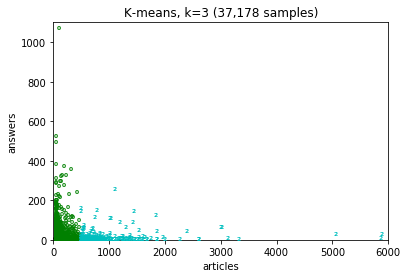

In [54]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
from kmeans import KMeansClassifier
import matplotlib.pyplot as plt

#加载数据集，DataFrame格式，最后将返回为一个matrix格式
def loadDataset(infile):
    df = pd.read_csv(infile, sep='\t', header=0, dtype=str, na_filter=False)
    return np.array(df).astype(np.float)

if __name__=="__main__":
    data_X = loadDataset(r"F:\MC\K-means\ans_article.txt")
    k = 3
    clf = KMeansClassifier(k)
    clf.fit(data_X)
    cents = clf._centroids
    labels = clf._labels
    sse = clf._sse
    colors = ['g','b','c','k','r','m','y','#e24fff','#524C90','#845868']
    for i in range(k):
        index = np.nonzero(labels==i)[0]
        x0 = data_X[index, 0]
        x1 = data_X[index, 1]
        y_i = i
        for j in range(len(x0)):
            plt.text(x0[j], x1[j], str(y_i), color=colors[i], \
                        fontdict={'weight': 'bold', 'size': 6})
        plt.scatter(cents[i,0],cents[i,1],marker='x',color=colors[i],\
                    linewidths=7)
    plt.title("K-means, k=3 (37,178 samples)")
    plt.axis([0,6000,0,1100])
    plt.xlabel('articles')
    plt.ylabel('answers')
    plt.show()